In [252]:
pip install -q seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: c:\Users\caiop\.pyenv\pyenv-win\versions\3.11.2\python.exe -m pip install --upgrade pip


In [253]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import tempfile
import os
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [254]:
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)
# Set random seed for reproducible results
tf.random.set_seed(22)

2.16.1


In [255]:
train_data, val_data, test_data = tfds.load("mnist",
                                            split=['train[10000:]', 'train[0:10000]', 'test'],
                                            batch_size=128, as_supervised=True)

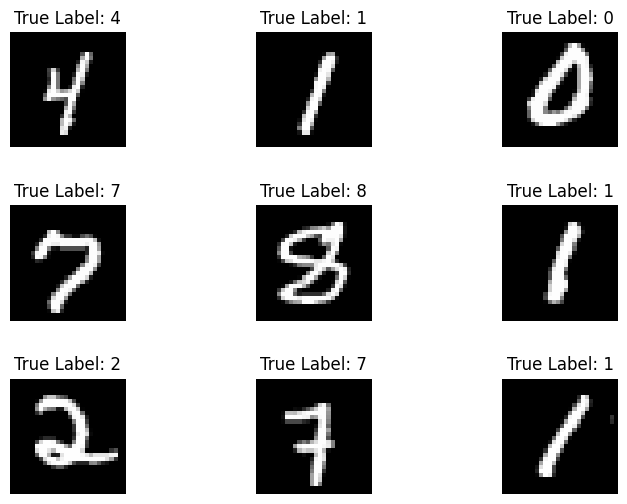

In [256]:
x_viz, y_viz = tfds.load("mnist", split=['train[:1500]'], batch_size=-1, as_supervised=True)[0]
x_viz = tf.squeeze(x_viz, axis=3)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis('off')
    plt.imshow(x_viz[i], cmap='gray')
    plt.title(f"True Label: {y_viz[i]}")
    plt.subplots_adjust(hspace=.5)

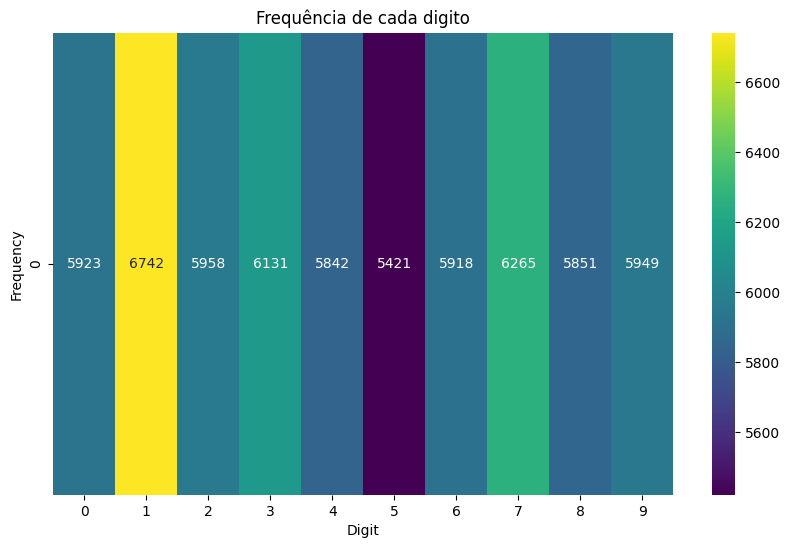

In [257]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Count the frequency of each digit in the training set
digit_counts = np.bincount(train_labels)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap([digit_counts], annot=True, cmap="viridis", fmt="d")
plt.title("Frequência de cada digito")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.show()

In [258]:
def preprocess(x, y):
  # Reshape
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling
  x = x/255
  return x, y

train_data, val_data = train_data.map(preprocess), val_data.map(preprocess)

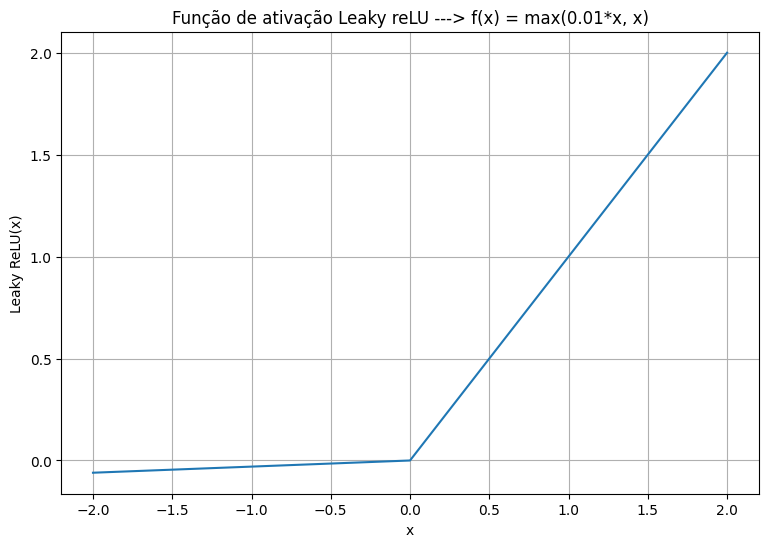

In [259]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
output = tf.nn.leaky_relu(x, alpha=0.03)

# Plotar o gráfico
plt.plot(x, output)
plt.xlabel('x')
plt.ylabel('Leaky ReLU(x)')
plt.title('Função de ativação Leaky reLU ---> f(x) = max(0.01*x, x)')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'função de ativação reLU')

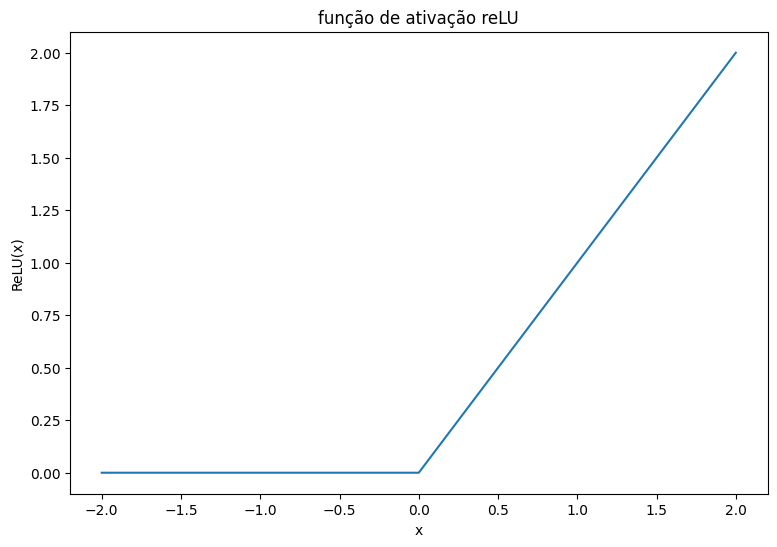

In [260]:
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.relu(x))
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('função de ativação reLU')

Text(0.5, 1.0, 'função de ativação Sigmoide')

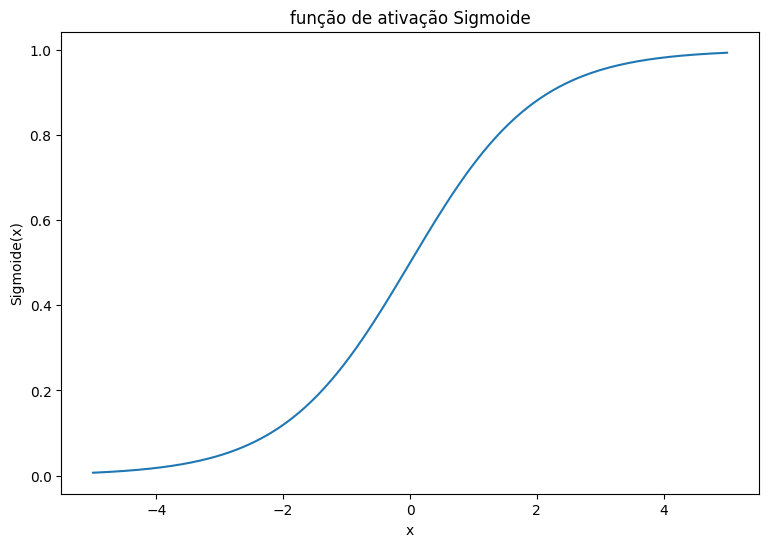

In [261]:
x = tf.linspace(-5, 5, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.sigmoid(x))
plt.xlabel('x')
plt.ylabel('Sigmoide(x)')
plt.title('função de ativação Sigmoide')

Text(0.5, 1.0, 'função de ativação Tahn')

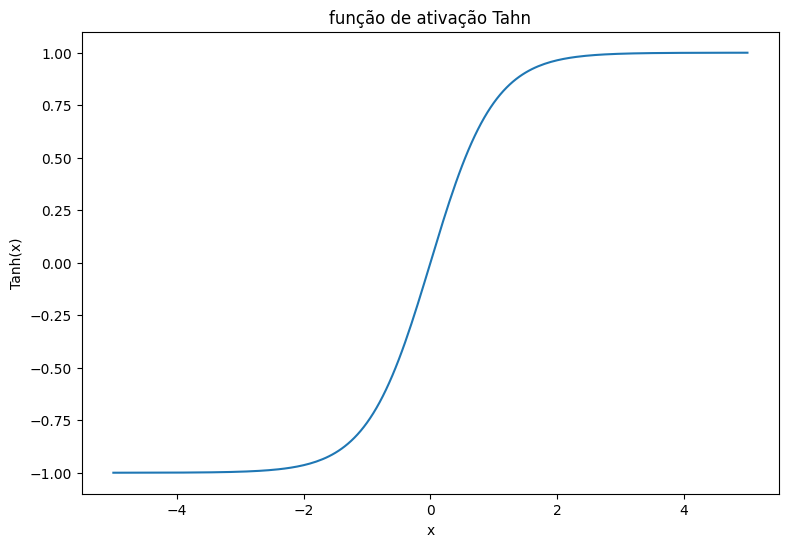

In [262]:
x = tf.linspace(-5, 5, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.tanh(x))
plt.xlabel('x')
plt.ylabel('Tanh(x)')
plt.title('função de ativação Tahn')

# Explicando a Softmax


A função de ativação softmax é usada principalmente em problemas de classificação onde necessitamos converter as saídas, também conhecidas como logits, em probabilidades que somam 1, basicamente estudando a chance de cada saída ser a escolhida, ou também a "certeza" do modelo. A função é dada pela seguinte equação:

$$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}} $$

Onde:
- $x_i$ é o logit para a classe $i$.
- $n$ é o número total de classes.

Abaixo é feito um pequeno plot para demonstrar a função.

Text(0.5, 1.0, 'função de ativação softmax')

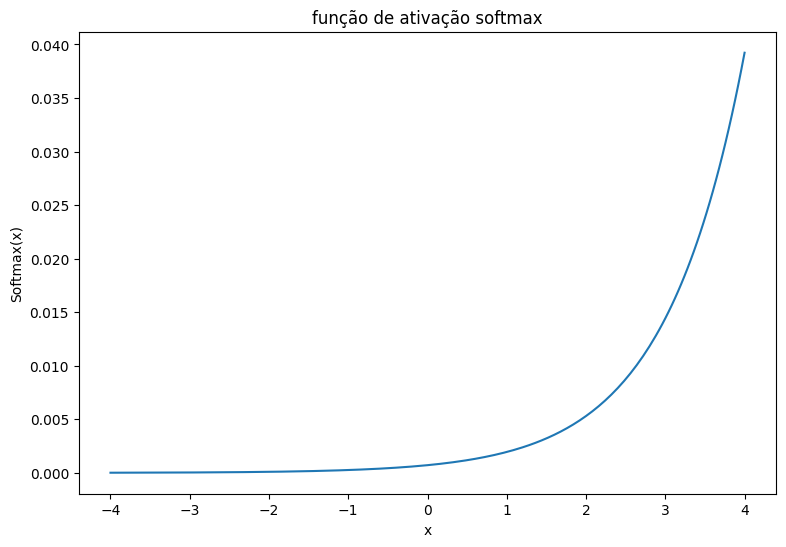

In [263]:
x = tf.linspace(-4, 4, 201)
x = tf.cast(x, tf.float32)
plt.plot(x, tf.nn.softmax(x, axis=0))
plt.xlabel('x')
plt.ylabel('Softmax(x)')
plt.title('função de ativação softmax')

In [264]:
def he_init(shape, alpha=0.01):
    stddev = np.sqrt(2 / ((1 + alpha**2) * shape[0]))
    return tf.random.normal(shape, stddev=stddev)

In [265]:
class DenseLayer(tf.Module):

  def __init__(self, out_dim, weight_init=he_init, activation=tf.identity):
    # Initialize the dimensions and activation functions
    self.out_dim = out_dim
    self.weight_init = weight_init
    self.activation = activation
    self.built = False

  def __call__(self, x):
    if not self.built:
      # Infer the input dimension based on first call
      self.in_dim = x.shape[1]
      # Initialize the weights and biases
      self.w = tf.Variable(self.weight_init(shape=(self.in_dim, self.out_dim)))
      self.b = tf.Variable(tf.zeros(shape=(self.out_dim,)))
      self.built = True
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

In [266]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers

  @tf.function
  def __call__(self, x, preds=False):
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

In [267]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=output_size)])

# Funções de Perda para Classificação Multiclasse

Em aprendizado de máquina, especialmente em tarefas que envolvem classificação multiclasse, selecionar uma função de perda apropriada é crucial para treinar modelos eficazes. Aqui estão quatro funções de perda comumente usadas para tarefas de classificação multiclasse:

1. **Perda de Entropia Cruzada (Perda Softmax)**
   - **Descrição**: A Perda de Entropia Cruzada mede o desempenho de um modelo de classificação cuja saída é um valor de probabilidade entre 0 e 1. Ela aumenta conforme a probabilidade prevista diverge da etiqueta real. É particularmente útil quando lidamos com probabilidades que são saídas da função softmax.
   - **Caso de Uso**: Tipicamente usada quando as classes são mutuamente exclusivas (por exemplo, classificar tipos de frutas).
   - **Fórmula**: $$ - \sum_{c=1}^M y_{o,c} \log(p_{o,c}) $$
     - Onde \(y\) é o indicador binário (0 ou 1) se a etiqueta de classe \(c\) é a classificação correta para a observação \(o\), e \(p\) é a probabilidade prevista de que a observação \(o\) seja da classe \(c\).

2. **Perda de Dobradiça Categórica (Hinge Loss)**
   - **Descrição**: Uma generalização da perda de dobradiça usada em classificação multiclasse. Ela mede a diferença entre a pontuação da classe correta e a maior pontuação da classe incorreta, garantindo uma margem entre elas.
   - **Caso de Uso**: Útil em classificação de "margem máxima", comumente vista em máquinas de vetores de suporte.
   - **Fórmula**: $$ \max(0, 1 + \max_{j \neq true} z_j - z_{true}) $$
     - Onde $(z_j)$ é a pontuação prevista para uma classe não verdadeira, e \(z_{true}\) é a pontuação para a classe verdadeira.

3. **Perda de Divergência de Kullback-Leibler (Divergência KL)**
   - **Descrição**: Mede como uma distribuição de probabilidade diverge de uma segunda, esperada distribuição de probabilidade. No aprendizado de máquina, é usada para comparar a distribuição de probabilidade prevista com a distribuição verdadeira.
   - **Caso de Uso**: Útil em casos onde as etiquetas são probabilidades (por exemplo, tópicos em um documento podem pertencer a várias categorias, e as categorias não são mutuamente exclusivas).
   - **Fórmula**: $$ \sum_{c=1}^M y_{o,c} \log\left(\frac{y_{o,c}}{p_{o,c}}\right) $$
     - Onde $(y_{o,c})$ é a distribuição de probabilidade real, e $(p_{o,c})$ é a distribuição de probabilidade prevista.

4. **Perda de Entropia Cruzada Esparsa (Sparse Categorical Cross-Entropy)**
   - **Descrição**: Uma variante da Perda de Entropia Cruzada que é usada quando as classes são mutuamente exclusivas e as etiquetas são fornecidas como inteiros. Ela converte etiquetas inteiras em forma binária para calcular a perda.
   - **Caso de Uso**: Eficiente para cenários onde o número de classes é grande, mas cada etiqueta é um inteiro (por exemplo, previsões de palavras em modelagem de linguagem).
   - **Fórmula**: Mesma da entropia cruzada, mas com tratamento para etiquetas esparsas por meio de codificação one-hot internamente.

Cada uma dessas funções de perda pode ser adaptada às características específicas de um conjunto de dados e à natureza do problema de classificação, garantindo que o modelo não apenas aprenda bem, mas também generalize efetivamente para novos dados não vistos.


In [268]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

In [269]:
def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(tf.nn.softmax(y_pred), axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

In [270]:
class GradientDescent:
    def __init__(self, learning_rate=0.01):
        # Initialize the learning rate
        self.learning_rate = learning_rate

    def apply_gradients(self, grads, vars):
        # Update the model variables given their gradients
        for grad, var in zip(grads, vars):
            update = self.learning_rate * grad
            var.assign_sub(update)  # This subtracts the gradient scaled by the learning rate from the variable

optimizer = GradientDescent(learning_rate=0.01)

In [271]:
def train_step(x_batch, y_batch, loss, acc, model, optimizer):
  # Update the model state given a batch of data
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  grads = tape.gradient(batch_loss, model.variables)
  optimizer.apply_gradients(grads, model.variables)
  return batch_loss, batch_acc

def val_step(x_batch, y_batch, loss, acc, model):
  # Evaluate the model on given a batch of validation data
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = acc(y_pred, y_batch)
  return batch_loss, batch_acc

In [272]:
def train_model(mlp, train_data, val_data, loss, acc, optimizer, epochs):
  # Initialize data structures
  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  # Format training loop and begin training
  for epoch in range(epochs):
    batch_losses_train, batch_accs_train = [], []
    batch_losses_val, batch_accs_val = [], []

    # Iterate over the training data
    for x_batch, y_batch in train_data:
      # Compute gradients and update the model's parameters
      batch_loss, batch_acc = train_step(x_batch, y_batch, loss, acc, mlp, optimizer)
      # Keep track of batch-level training performance
      batch_losses_train.append(batch_loss)
      batch_accs_train.append(batch_acc)

    # Iterate over the validation data
    for x_batch, y_batch in val_data:
      batch_loss, batch_acc = val_step(x_batch, y_batch, loss, acc, mlp)
      batch_losses_val.append(batch_loss)
      batch_accs_val.append(batch_acc)

    # Keep track of epoch-level model performance
    train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
    val_loss, val_acc = tf.reduce_mean(batch_losses_val), tf.reduce_mean(batch_accs_val)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch: {epoch}")
    print(f"Training loss: {train_loss:.3f}, Training accuracy: {train_acc:.3f}")
    print(f"Validation loss: {val_loss:.3f}, Validation accuracy: {val_acc:.3f}")
  return train_losses, train_accs, val_losses, val_accs

# Primeiro treinamento

Utilizamos 10 épocas, com o otimizador Gradient Descent, Leaky ReLU, Cross entropy, HE initialization

In [273]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=GradientDescent(), epochs=10)

Epoch: 0
Training loss: 0.901, Training accuracy: 0.788
Validation loss: 0.491, Validation accuracy: 0.873
Epoch: 1
Training loss: 0.421, Training accuracy: 0.888
Validation loss: 0.372, Validation accuracy: 0.899
Epoch: 2
Training loss: 0.348, Training accuracy: 0.902
Validation loss: 0.327, Validation accuracy: 0.909
Epoch: 3
Training loss: 0.313, Training accuracy: 0.911
Validation loss: 0.301, Validation accuracy: 0.915
Epoch: 4
Training loss: 0.290, Training accuracy: 0.918
Validation loss: 0.282, Validation accuracy: 0.920
Epoch: 5
Training loss: 0.272, Training accuracy: 0.924
Validation loss: 0.267, Validation accuracy: 0.924
Epoch: 6
Training loss: 0.258, Training accuracy: 0.927
Validation loss: 0.255, Validation accuracy: 0.928
Epoch: 7
Training loss: 0.246, Training accuracy: 0.931
Validation loss: 0.245, Validation accuracy: 0.930
Epoch: 8
Training loss: 0.235, Training accuracy: 0.934
Validation loss: 0.236, Validation accuracy: 0.933
Epoch: 9
Training loss: 0.226, Traini

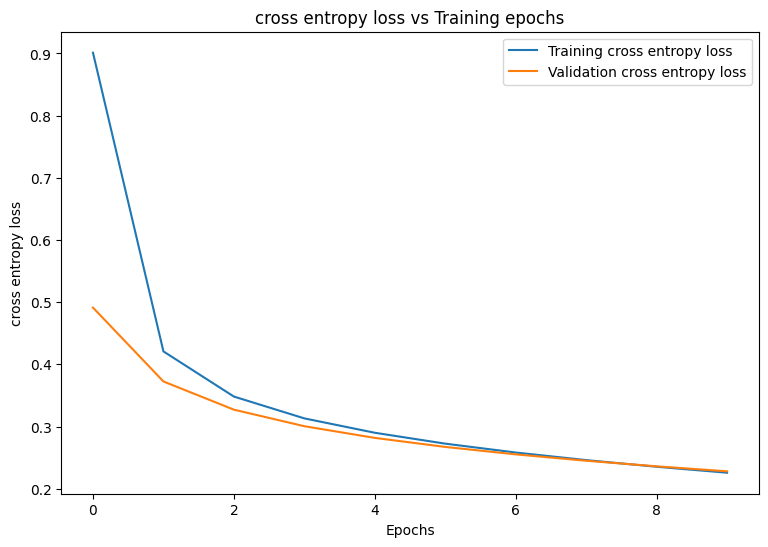

In [274]:
def plot_metrics(train_metric, val_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(val_metric)), val_metric, label = f"Validation {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training epochs")

plot_metrics(train_losses, val_losses, "cross entropy loss")

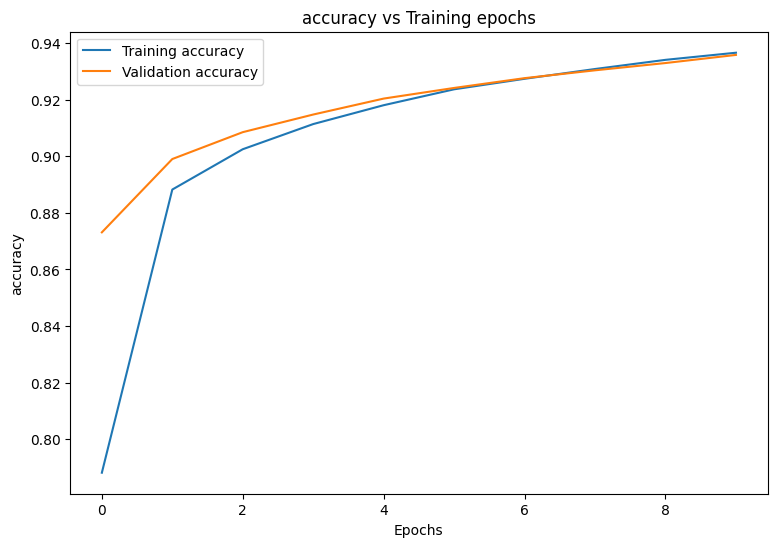

In [275]:
plot_metrics(train_accs, val_accs, "accuracy")

In [276]:
class ExportModule(tf.Module):
  def __init__(self, model, preprocess, class_pred):
    # Initialize pre and postprocessing functions
    self.model = model
    self.preprocess = preprocess
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None, None, None], dtype=tf.uint8)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.preprocess(x)
    y = self.model(x)
    y = self.class_pred(y)
    return y

In [277]:
def preprocess_test(x):
  # The export module takes in unprocessed and unlabeled data
  x = tf.reshape(x, shape=[-1, 784])
  x = x/255
  return x

def class_pred_test(y):
  # Generate class predictions from MLP output
  return tf.argmax(tf.nn.softmax(y), axis=1)


mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)



INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpyc5o8g81\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpyc5o8g81\mlp_model_export\assets


In [278]:
mlp_loaded = tf.saved_model.load(save_path)

In [279]:
def accuracy_score(y_pred, y):
  # Generic accuracy function
  is_equal = tf.equal(y_pred, y)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.939


In [280]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 5: 0.901
Digit 2: 0.913
Digit 8: 0.922
Digit 9: 0.924
Digit 7: 0.928
Digit 3: 0.936
Digit 4: 0.942
Digit 6: 0.954
Digit 1: 0.981
Digit 0: 0.982


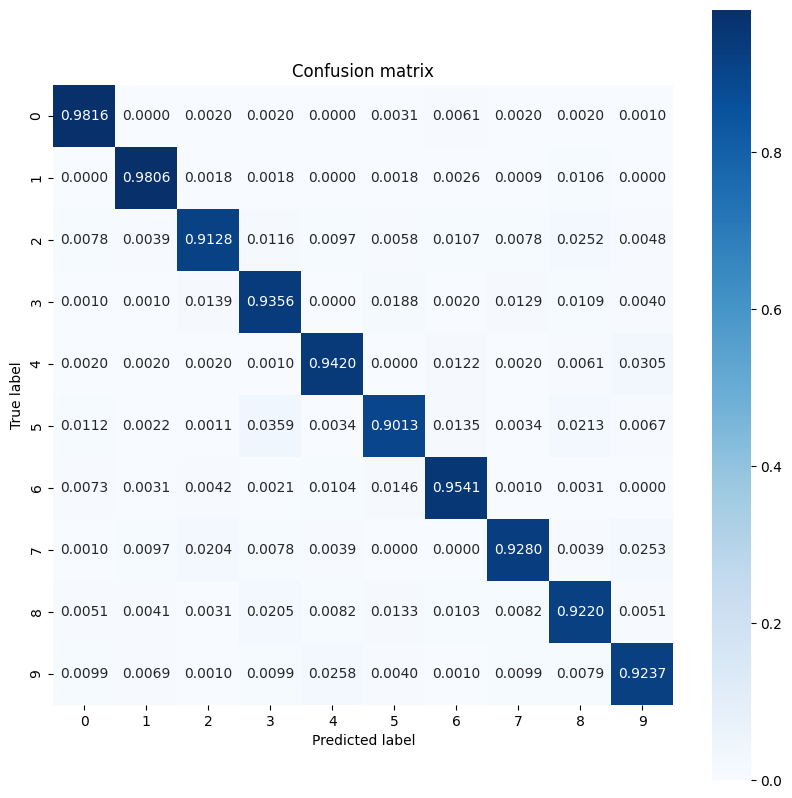

In [281]:
import sklearn.metrics as sk_metrics

def show_confusion_matrix(test_labels, test_classes):
  # Compute confusion matrix and normalize
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(test_labels.numpy(), 
                                          test_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(10)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(y_test, test_classes)

In [282]:
from sklearn.metrics import precision_score, recall_score

# Assuming y_test are the true labels
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.9383671655036222
Recall: 0.9381728756754928


# Segundo treinamento

Gradient descent, 10 epocas, sigmoid, xavier init, cross entropy

In [283]:
def xavier_init(shape):
    # Computes the xavier initialization values for a weight matrix
    in_dim, out_dim = shape
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
    weight_vals = tf.random.uniform(shape=(in_dim, out_dim),
                                  minval=-xavier_lim, maxval=xavier_lim, seed=22)
    return weight_vals

In [284]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu, weight_init=xavier_init),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu, weight_init=xavier_init),
    DenseLayer(out_dim=output_size)])

In [285]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=GradientDescent(), epochs=10)

Epoch: 0
Training loss: 1.121, Training accuracy: 0.748
Validation loss: 0.580, Validation accuracy: 0.859
Epoch: 1
Training loss: 0.480, Training accuracy: 0.876
Validation loss: 0.411, Validation accuracy: 0.890
Epoch: 2
Training loss: 0.384, Training accuracy: 0.894
Validation loss: 0.355, Validation accuracy: 0.903
Epoch: 3
Training loss: 0.342, Training accuracy: 0.904
Validation loss: 0.324, Validation accuracy: 0.911
Epoch: 4
Training loss: 0.317, Training accuracy: 0.910
Validation loss: 0.304, Validation accuracy: 0.915
Epoch: 5
Training loss: 0.299, Training accuracy: 0.915
Validation loss: 0.288, Validation accuracy: 0.919
Epoch: 6
Training loss: 0.284, Training accuracy: 0.919
Validation loss: 0.276, Validation accuracy: 0.921
Epoch: 7
Training loss: 0.272, Training accuracy: 0.923
Validation loss: 0.266, Validation accuracy: 0.924
Epoch: 8
Training loss: 0.261, Training accuracy: 0.926
Validation loss: 0.257, Validation accuracy: 0.927
Epoch: 9
Training loss: 0.251, Traini

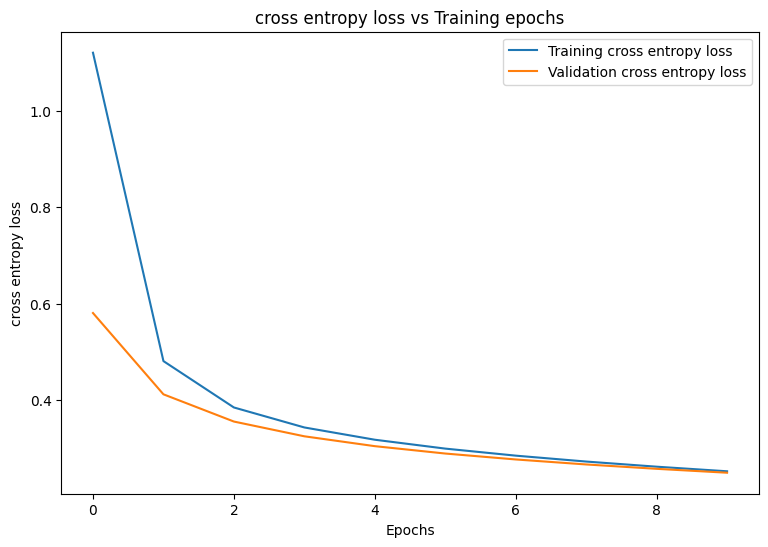

In [286]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

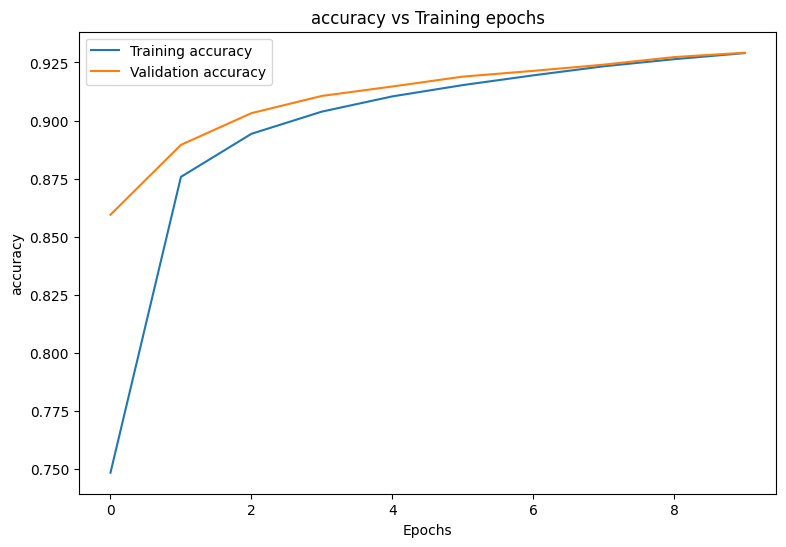

In [287]:
plot_metrics(train_accs, val_accs, "accuracy")

In [288]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpw3z73r05\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpw3z73r05\mlp_model_export\assets


In [289]:
mlp_loaded = tf.saved_model.load(save_path)

In [290]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.933


In [291]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 5: 0.891
Digit 2: 0.901
Digit 8: 0.908
Digit 9: 0.912
Digit 7: 0.919
Digit 3: 0.929
Digit 4: 0.942
Digit 6: 0.957
Digit 1: 0.980
Digit 0: 0.981


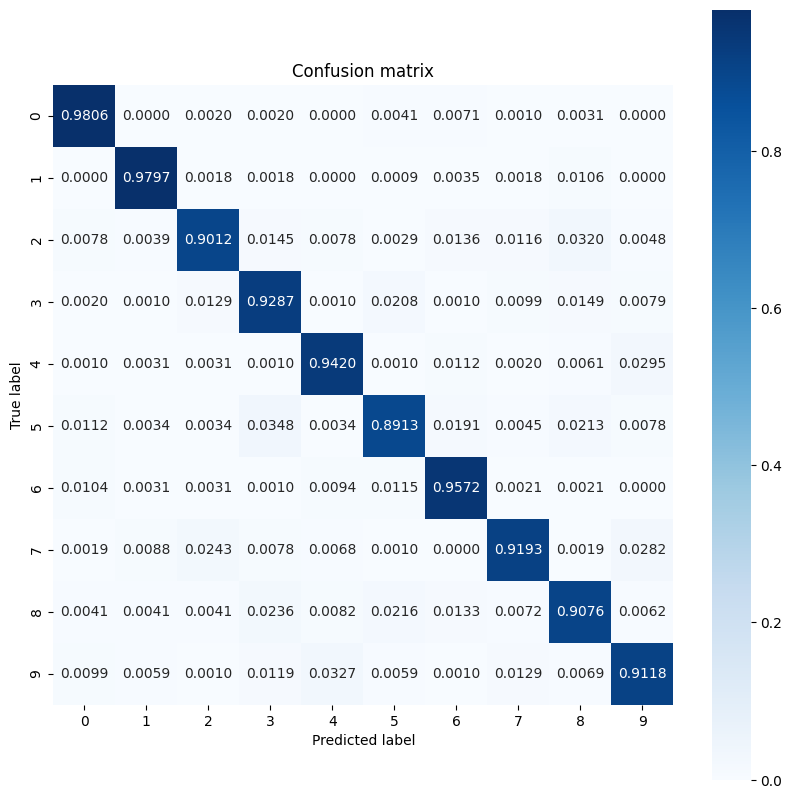

In [292]:
show_confusion_matrix(y_test, test_classes)

In [293]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 0.9319994973311237
Recall: 0.9319288985410884


# Segundo treinamento

Utilizando o otimizador Adam, HE initialization, Leaky ReLU, cross entropy

In [294]:
class Adam: 
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      self.built = False

    def apply_gradients(self, grads, vars):
      # Initialize variables on the first call
      if not self.built:
        for var in vars:
          v = tf.Variable(tf.zeros(shape=var.shape))
          s = tf.Variable(tf.zeros(shape=var.shape))
          self.v_dvar.append(v)
          self.s_dvar.append(s)
        self.built = True
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return

In [295]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.201, Training accuracy: 0.941
Validation loss: 0.135, Validation accuracy: 0.960
Epoch: 1
Training loss: 0.101, Training accuracy: 0.969
Validation loss: 0.131, Validation accuracy: 0.961
Epoch: 2
Training loss: 0.068, Training accuracy: 0.979
Validation loss: 0.122, Validation accuracy: 0.965
Epoch: 3
Training loss: 0.051, Training accuracy: 0.984
Validation loss: 0.109, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.044, Training accuracy: 0.986
Validation loss: 0.118, Validation accuracy: 0.972
Epoch: 5
Training loss: 0.036, Training accuracy: 0.988
Validation loss: 0.121, Validation accuracy: 0.970
Epoch: 6
Training loss: 0.034, Training accuracy: 0.988
Validation loss: 0.155, Validation accuracy: 0.968
Epoch: 7
Training loss: 0.031, Training accuracy: 0.989
Validation loss: 0.169, Validation accuracy: 0.963
Epoch: 8
Training loss: 0.035, Training accuracy: 0.988
Validation loss: 0.122, Validation accuracy: 0.975
Epoch: 9
Training loss: 0.029, Traini

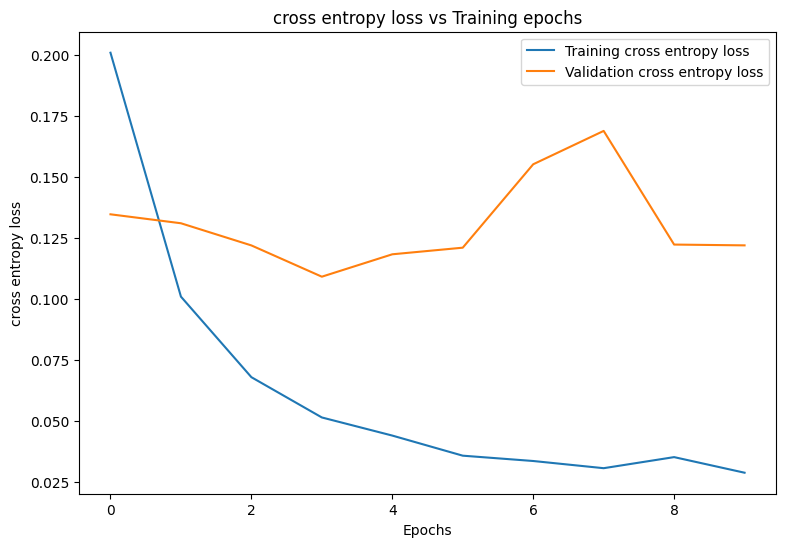

In [296]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

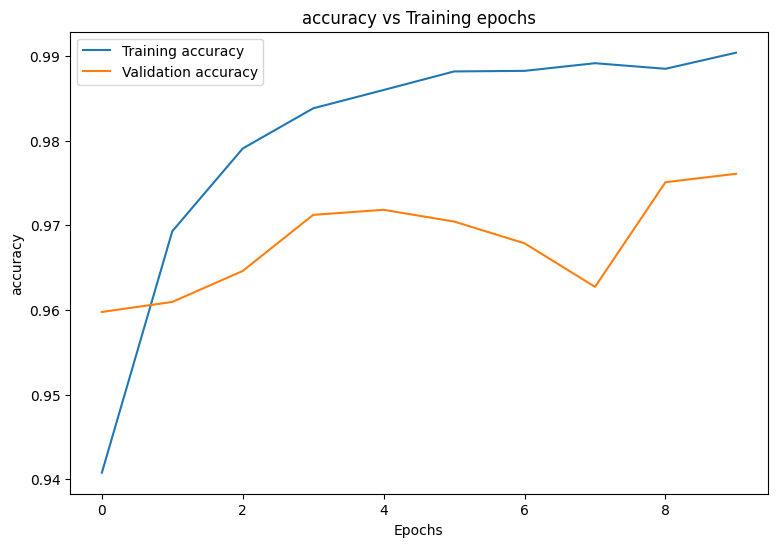

In [297]:
plot_metrics(train_accs, val_accs, "accuracy")

In [298]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp9v9atlin\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp9v9atlin\mlp_model_export\assets


In [299]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.974


In [300]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.947
Digit 5: 0.955
Digit 3: 0.967
Digit 4: 0.969
Digit 8: 0.976
Digit 6: 0.978
Digit 2: 0.983
Digit 9: 0.984
Digit 0: 0.988
Digit 1: 0.992


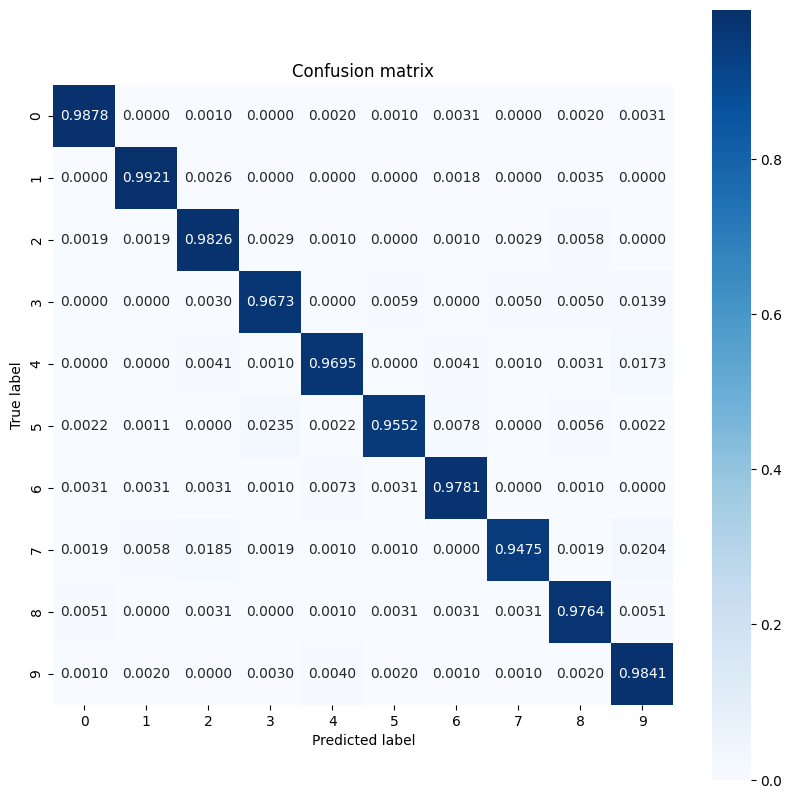

In [301]:
show_confusion_matrix(y_test, test_classes)

In [302]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9745989618719182
Recall: 0.9740396412919218


# Terceiro treinamento

Adam, sigmoid, HE initialization, cross entropy

In [303]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.sigmoid),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.sigmoid),
    DenseLayer(out_dim=output_size)])

In [304]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.508, Training accuracy: 0.852
Validation loss: 0.260, Validation accuracy: 0.923
Epoch: 1
Training loss: 0.230, Training accuracy: 0.932
Validation loss: 0.201, Validation accuracy: 0.940
Epoch: 2
Training loss: 0.170, Training accuracy: 0.949
Validation loss: 0.163, Validation accuracy: 0.950
Epoch: 3
Training loss: 0.130, Training accuracy: 0.961
Validation loss: 0.138, Validation accuracy: 0.958
Epoch: 4
Training loss: 0.102, Training accuracy: 0.970
Validation loss: 0.119, Validation accuracy: 0.965
Epoch: 5
Training loss: 0.081, Training accuracy: 0.977
Validation loss: 0.107, Validation accuracy: 0.967
Epoch: 6
Training loss: 0.065, Training accuracy: 0.981
Validation loss: 0.100, Validation accuracy: 0.970
Epoch: 7
Training loss: 0.052, Training accuracy: 0.985
Validation loss: 0.095, Validation accuracy: 0.973
Epoch: 8
Training loss: 0.042, Training accuracy: 0.988
Validation loss: 0.091, Validation accuracy: 0.974
Epoch: 9
Training loss: 0.033, Traini

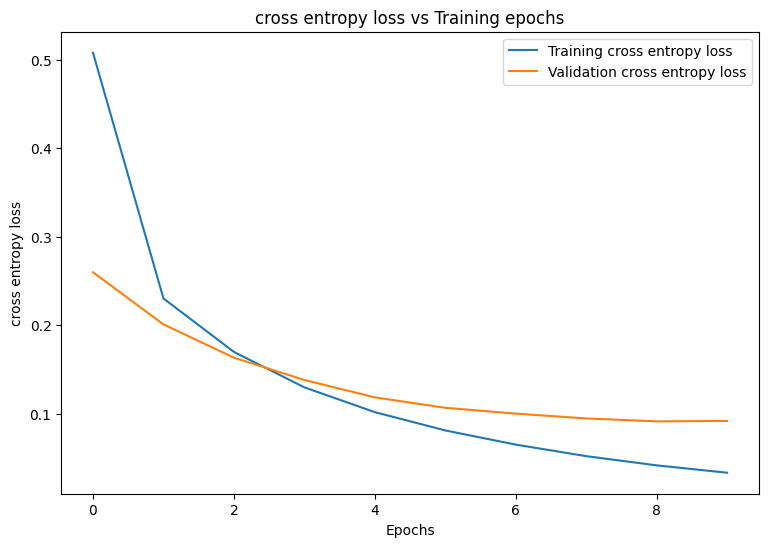

In [305]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

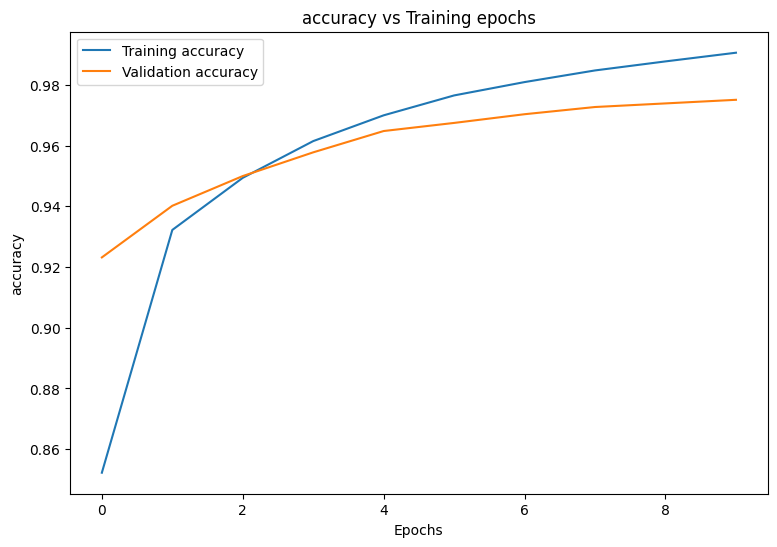

In [306]:
plot_metrics(train_accs, val_accs, "accuracy")

In [307]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp25yacvq3\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp25yacvq3\mlp_model_export\assets


In [308]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.975


In [309]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.958
Digit 9: 0.960
Digit 5: 0.965
Digit 8: 0.967
Digit 4: 0.973
Digit 6: 0.975
Digit 3: 0.985
Digit 2: 0.985
Digit 0: 0.989
Digit 1: 0.994


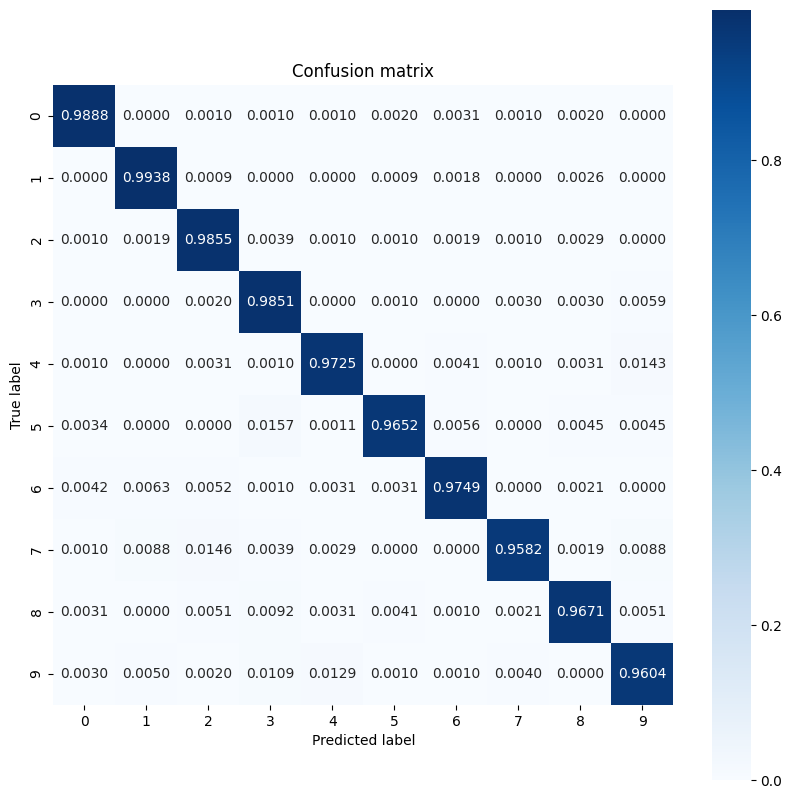

In [310]:
show_confusion_matrix(y_test, test_classes)

In [311]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.975712109377627
Recall: 0.9751595062487765


# Quarto treinamento

Xavier initialization , leaky ReLU, ADAM, cross entropy

In [312]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu, weight_init=xavier_init),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu, weight_init=xavier_init),
    DenseLayer(out_dim=output_size)])

In [313]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.247, Training accuracy: 0.928
Validation loss: 0.144, Validation accuracy: 0.957
Epoch: 1
Training loss: 0.104, Training accuracy: 0.968
Validation loss: 0.131, Validation accuracy: 0.960
Epoch: 2
Training loss: 0.070, Training accuracy: 0.979
Validation loss: 0.107, Validation accuracy: 0.969
Epoch: 3
Training loss: 0.052, Training accuracy: 0.983
Validation loss: 0.112, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.043, Training accuracy: 0.986
Validation loss: 0.131, Validation accuracy: 0.969
Epoch: 5
Training loss: 0.039, Training accuracy: 0.987
Validation loss: 0.136, Validation accuracy: 0.970
Epoch: 6
Training loss: 0.035, Training accuracy: 0.989
Validation loss: 0.125, Validation accuracy: 0.973
Epoch: 7
Training loss: 0.030, Training accuracy: 0.990
Validation loss: 0.138, Validation accuracy: 0.970
Epoch: 8
Training loss: 0.027, Training accuracy: 0.991
Validation loss: 0.137, Validation accuracy: 0.972
Epoch: 9
Training loss: 0.022, Traini

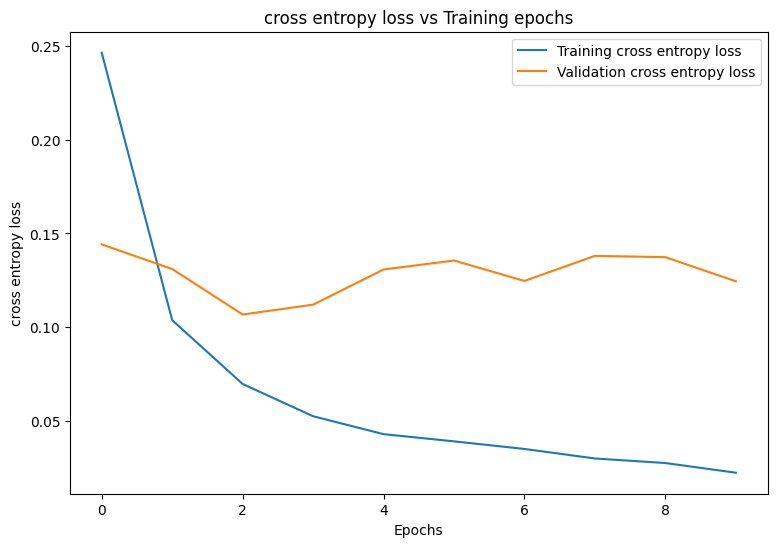

In [314]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

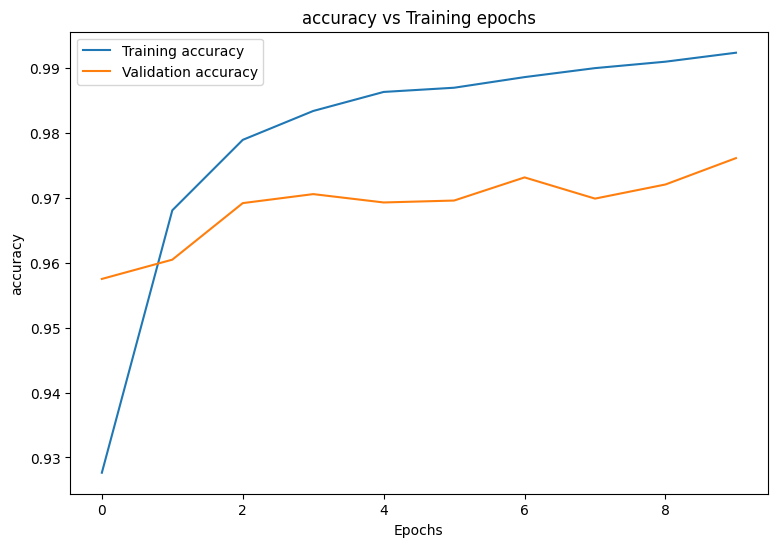

In [315]:
plot_metrics(train_accs, val_accs, "accuracy")

In [316]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmprdjm9uwf\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmprdjm9uwf\mlp_model_export\assets


In [317]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.975


In [318]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 5: 0.964
Digit 9: 0.964
Digit 3: 0.966
Digit 8: 0.968
Digit 7: 0.974
Digit 2: 0.976
Digit 6: 0.978
Digit 4: 0.979
Digit 0: 0.984
Digit 1: 0.997


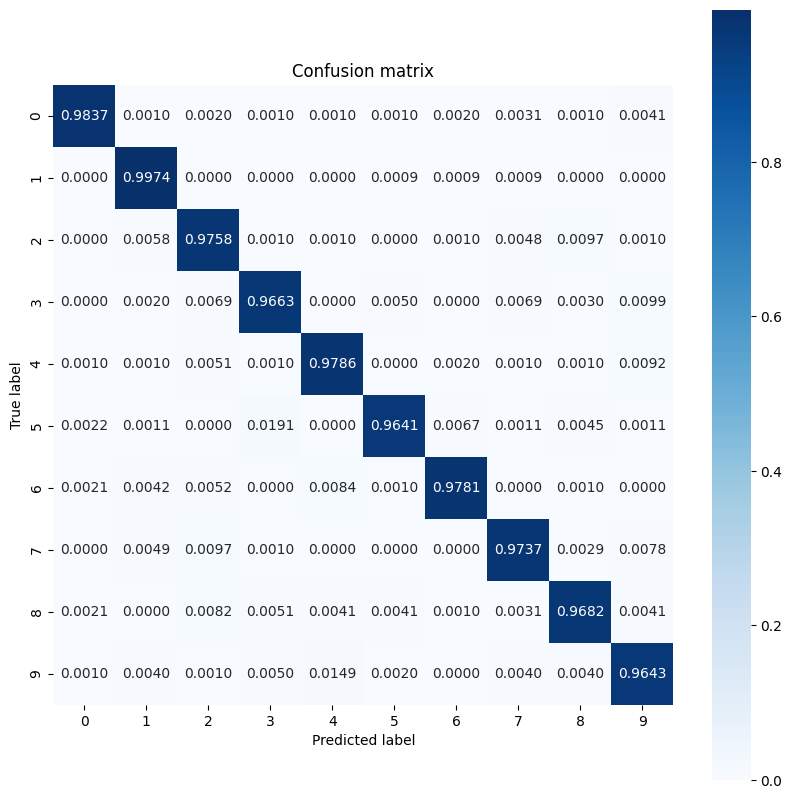

In [319]:
show_confusion_matrix(y_test, test_classes)

In [320]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9756029523742791
Recall: 0.9750191091975973


# Quinto treinamento

Sigmoid, Xavier Init, ADAM, Cross entropy

In [321]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.sigmoid, weight_init=xavier_init),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.sigmoid, weight_init=xavier_init),
    DenseLayer(out_dim=output_size)])

In [322]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.527, Training accuracy: 0.846
Validation loss: 0.260, Validation accuracy: 0.923
Epoch: 1
Training loss: 0.232, Training accuracy: 0.932
Validation loss: 0.201, Validation accuracy: 0.940
Epoch: 2
Training loss: 0.172, Training accuracy: 0.949
Validation loss: 0.163, Validation accuracy: 0.950
Epoch: 3
Training loss: 0.132, Training accuracy: 0.961
Validation loss: 0.138, Validation accuracy: 0.958
Epoch: 4
Training loss: 0.103, Training accuracy: 0.970
Validation loss: 0.119, Validation accuracy: 0.964
Epoch: 5
Training loss: 0.082, Training accuracy: 0.976
Validation loss: 0.106, Validation accuracy: 0.969
Epoch: 6
Training loss: 0.066, Training accuracy: 0.981
Validation loss: 0.099, Validation accuracy: 0.971
Epoch: 7
Training loss: 0.052, Training accuracy: 0.985
Validation loss: 0.093, Validation accuracy: 0.974
Epoch: 8
Training loss: 0.042, Training accuracy: 0.988
Validation loss: 0.090, Validation accuracy: 0.974
Epoch: 9
Training loss: 0.033, Traini

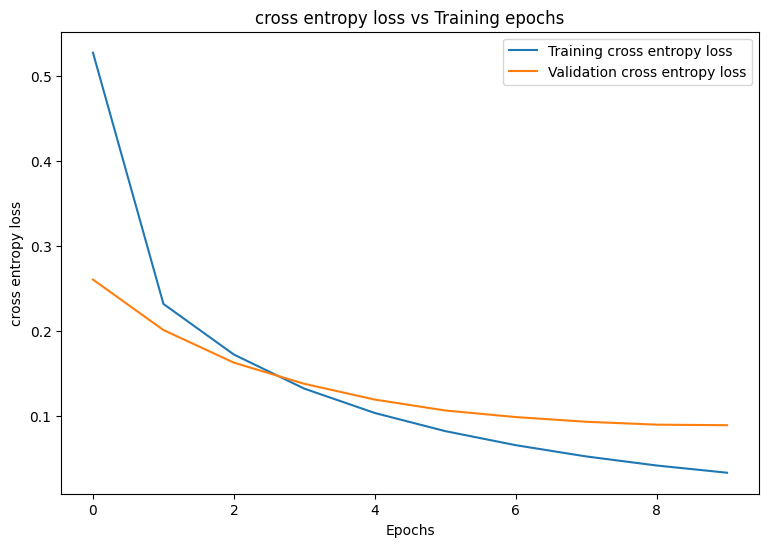

In [323]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

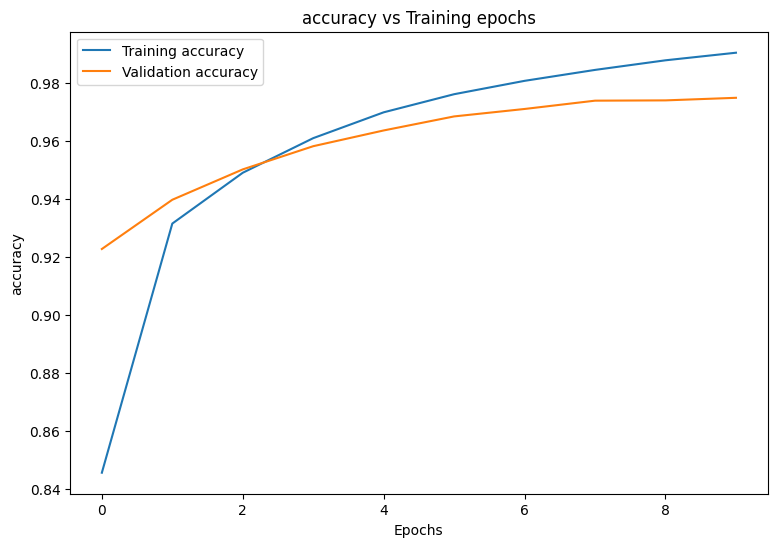

In [324]:
plot_metrics(train_accs, val_accs, "accuracy")

In [325]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpwua7nsfp\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpwua7nsfp\mlp_model_export\assets


In [326]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.974


In [327]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 7: 0.954
Digit 9: 0.960
Digit 8: 0.964
Digit 5: 0.964
Digit 6: 0.970
Digit 4: 0.977
Digit 2: 0.979
Digit 3: 0.985
Digit 0: 0.990
Digit 1: 0.993


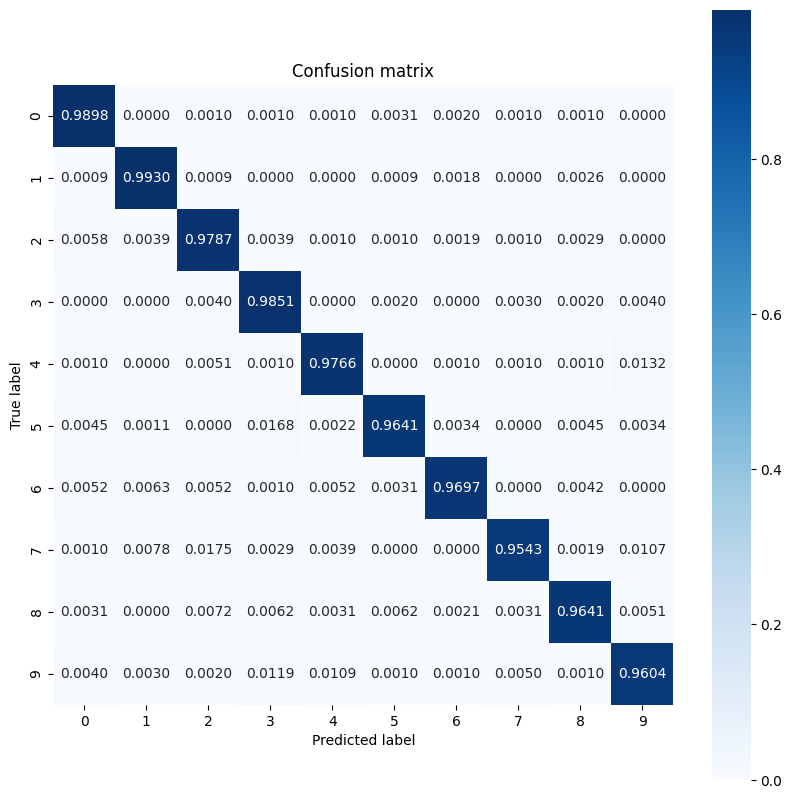

In [328]:
show_confusion_matrix(y_test, test_classes)

In [329]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9741131457465431
Recall: 0.9735713371768524


# Sexto treinamento

Adam, leaky ReLU, HE init, 15 epocas, 4 hidden layers

In [330]:
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_3_size = 300
hidden_layer_4_size = 100
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=output_size)])

In [331]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=15)

Epoch: 0
Training loss: 0.230, Training accuracy: 0.931
Validation loss: 0.140, Validation accuracy: 0.960
Epoch: 1
Training loss: 0.104, Training accuracy: 0.968
Validation loss: 0.132, Validation accuracy: 0.961
Epoch: 2
Training loss: 0.071, Training accuracy: 0.977
Validation loss: 0.129, Validation accuracy: 0.963
Epoch: 3
Training loss: 0.057, Training accuracy: 0.982
Validation loss: 0.111, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.054, Training accuracy: 0.983
Validation loss: 0.140, Validation accuracy: 0.967
Epoch: 5
Training loss: 0.044, Training accuracy: 0.985
Validation loss: 0.125, Validation accuracy: 0.972
Epoch: 6
Training loss: 0.042, Training accuracy: 0.986
Validation loss: 0.133, Validation accuracy: 0.970
Epoch: 7
Training loss: 0.043, Training accuracy: 0.987
Validation loss: 0.145, Validation accuracy: 0.968
Epoch: 8
Training loss: 0.034, Training accuracy: 0.989
Validation loss: 0.120, Validation accuracy: 0.974
Epoch: 9
Training loss: 0.033, Traini

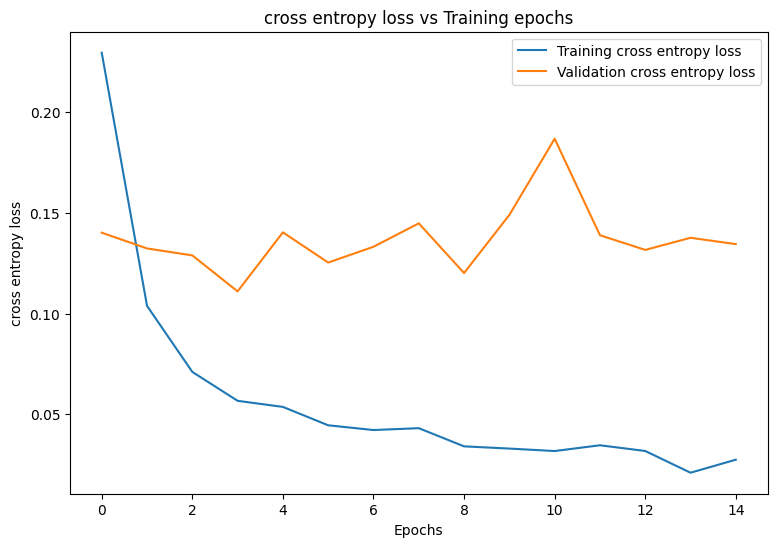

In [332]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

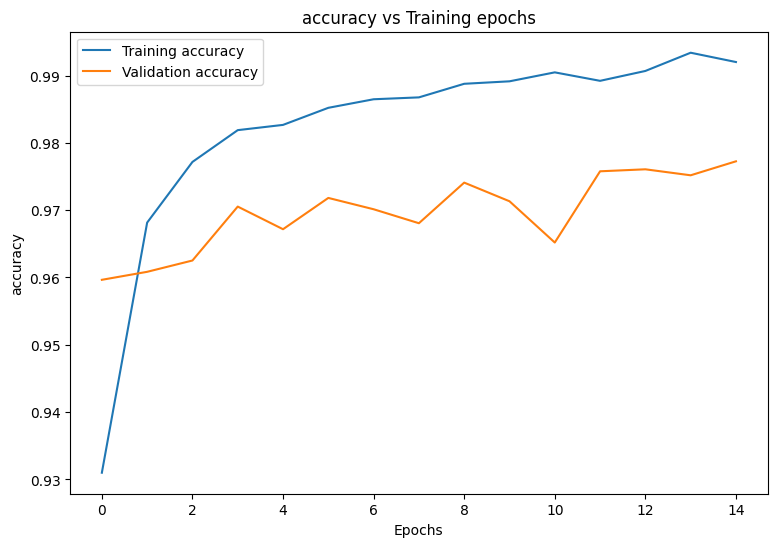

In [333]:
plot_metrics(train_accs, val_accs, "accuracy")

In [334]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpzcds2ku2\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmpzcds2ku2\mlp_model_export\assets


In [335]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.977


In [336]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 8: 0.959
Digit 7: 0.965
Digit 6: 0.972
Digit 4: 0.974
Digit 3: 0.976
Digit 9: 0.977
Digit 5: 0.978
Digit 2: 0.986
Digit 1: 0.989
Digit 0: 0.992


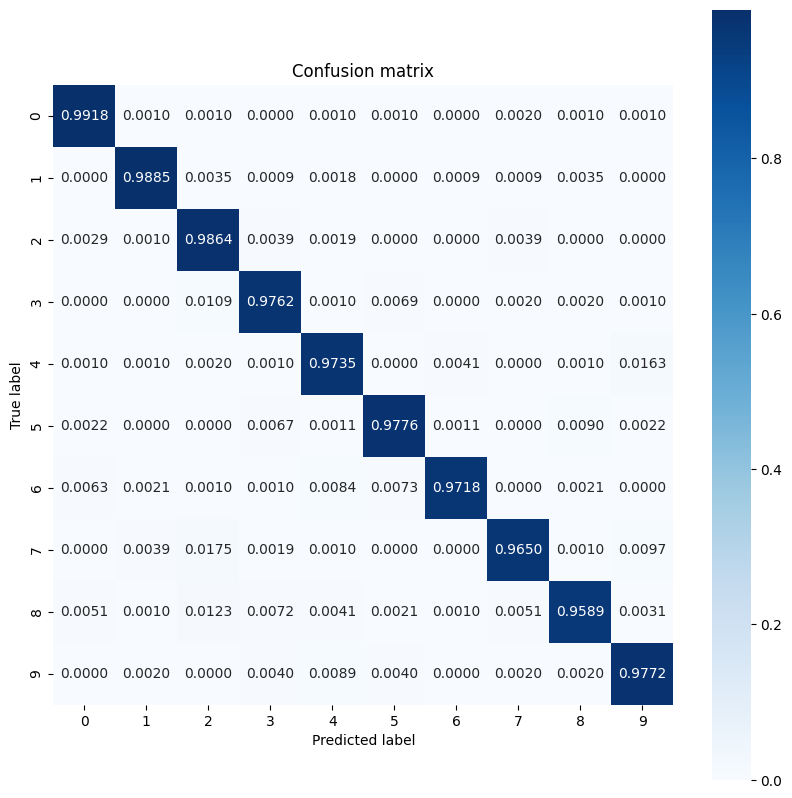

In [337]:
show_confusion_matrix(y_test, test_classes)

In [338]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9769946277041754
Recall: 0.9767090839897298


# Sétimo treinamento

Paramêtros semelhantes ao sexto, com dropout

In [348]:
from tensorflow.keras.layers import Dropout

hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_3_size = 300
hidden_layer_4_size = 100
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu),
    Dropout(0.2),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu),
    Dropout(0.2),
    DenseLayer(out_dim=hidden_layer_3_size, activation=tf.nn.leaky_relu),
    Dropout(0.2),
    DenseLayer(out_dim=hidden_layer_4_size, activation=tf.nn.leaky_relu),
    Dropout(0.2),
    DenseLayer(out_dim=output_size)])

In [349]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=15)

Epoch: 0
Training loss: 0.230, Training accuracy: 0.931
Validation loss: 0.140, Validation accuracy: 0.960
Epoch: 1
Training loss: 0.104, Training accuracy: 0.968
Validation loss: 0.132, Validation accuracy: 0.961
Epoch: 2
Training loss: 0.071, Training accuracy: 0.977
Validation loss: 0.129, Validation accuracy: 0.963
Epoch: 3
Training loss: 0.057, Training accuracy: 0.982
Validation loss: 0.111, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.054, Training accuracy: 0.983
Validation loss: 0.140, Validation accuracy: 0.967
Epoch: 5
Training loss: 0.044, Training accuracy: 0.985
Validation loss: 0.125, Validation accuracy: 0.972
Epoch: 6
Training loss: 0.042, Training accuracy: 0.986
Validation loss: 0.133, Validation accuracy: 0.970
Epoch: 7
Training loss: 0.043, Training accuracy: 0.987
Validation loss: 0.145, Validation accuracy: 0.968
Epoch: 8
Training loss: 0.034, Training accuracy: 0.989
Validation loss: 0.120, Validation accuracy: 0.974
Epoch: 9
Training loss: 0.033, Traini

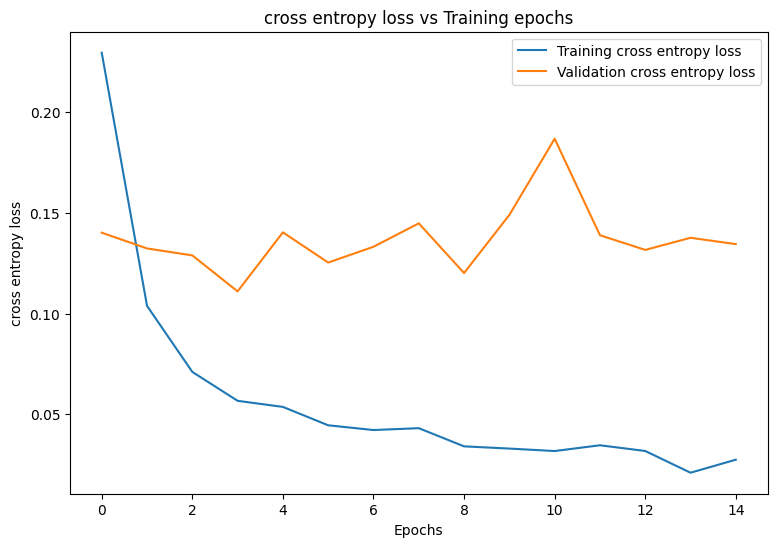

In [350]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

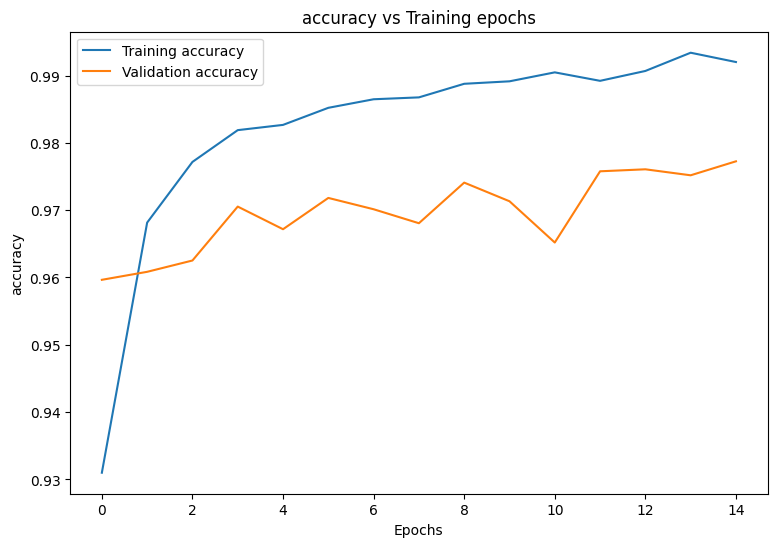

In [351]:
plot_metrics(train_accs, val_accs, "accuracy")

In [352]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmphgn46f1z\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmphgn46f1z\mlp_model_export\assets


In [353]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.977


In [354]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 8: 0.959
Digit 7: 0.965
Digit 6: 0.972
Digit 4: 0.974
Digit 3: 0.976
Digit 9: 0.977
Digit 5: 0.978
Digit 2: 0.986
Digit 1: 0.989
Digit 0: 0.992


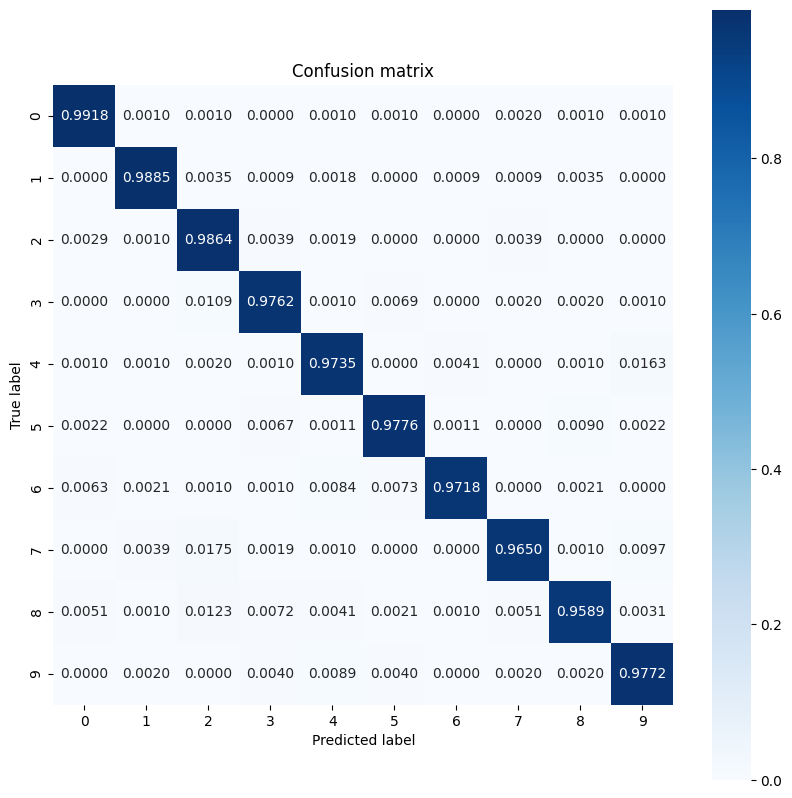

In [355]:
show_confusion_matrix(y_test, test_classes)

In [356]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9769946277041754
Recall: 0.9767090839897298


# Oitavo treinamento 

Paramêtros semelhantes ao sexto, porém com 2 hidden layers, e mais neurônios em cada layers, 10 épocas 

In [339]:
hidden_layer_1_size = 1000
hidden_layer_2_size = 800
output_size = 10

mlp_model = MLP([
    DenseLayer(out_dim=hidden_layer_1_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=hidden_layer_2_size, activation=tf.nn.leaky_relu),
    DenseLayer(out_dim=output_size)])

In [340]:
train_losses, train_accs, val_losses, val_accs = train_model(mlp_model, train_data, val_data,
                                                             loss=cross_entropy_loss, acc=accuracy,
                                                             optimizer=Adam(), epochs=10)

Epoch: 0
Training loss: 0.223, Training accuracy: 0.933
Validation loss: 0.124, Validation accuracy: 0.962
Epoch: 1
Training loss: 0.097, Training accuracy: 0.970
Validation loss: 0.126, Validation accuracy: 0.964
Epoch: 2
Training loss: 0.068, Training accuracy: 0.979
Validation loss: 0.127, Validation accuracy: 0.965
Epoch: 3
Training loss: 0.052, Training accuracy: 0.983
Validation loss: 0.118, Validation accuracy: 0.971
Epoch: 4
Training loss: 0.044, Training accuracy: 0.985
Validation loss: 0.150, Validation accuracy: 0.965
Epoch: 5
Training loss: 0.039, Training accuracy: 0.987
Validation loss: 0.154, Validation accuracy: 0.964
Epoch: 6
Training loss: 0.040, Training accuracy: 0.987
Validation loss: 0.147, Validation accuracy: 0.971
Epoch: 7
Training loss: 0.035, Training accuracy: 0.988
Validation loss: 0.141, Validation accuracy: 0.972
Epoch: 8
Training loss: 0.036, Training accuracy: 0.989
Validation loss: 0.166, Validation accuracy: 0.969
Epoch: 9
Training loss: 0.034, Traini

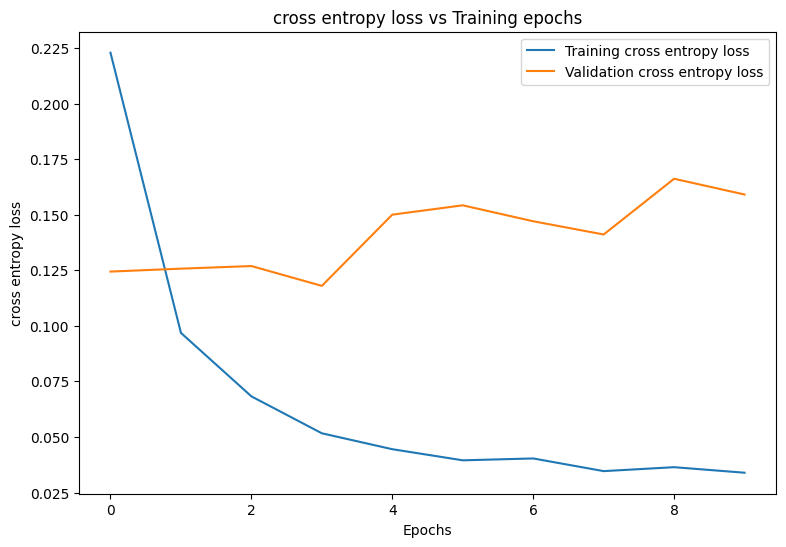

In [341]:
plot_metrics(train_losses, val_losses, "cross entropy loss")

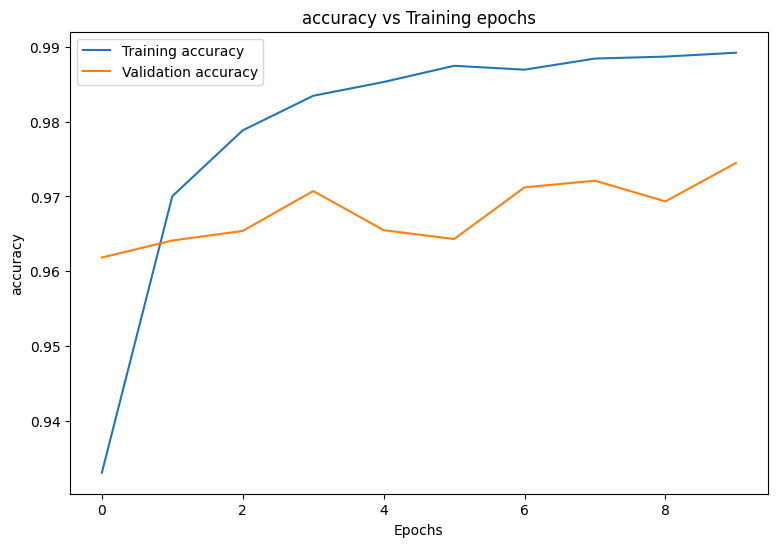

In [342]:
plot_metrics(train_accs, val_accs, "accuracy")

In [343]:
mlp_model_export = ExportModule(model=mlp_model,
                                preprocess=preprocess_test,
                                class_pred=class_pred_test)

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'mlp_model_export')
tf.saved_model.save(mlp_model_export, save_path)

mlp_loaded = tf.saved_model.load(save_path)

INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp1nueg8oy\mlp_model_export\assets


INFO:tensorflow:Assets written to: C:\Users\caiop\AppData\Local\Temp\tmp1nueg8oy\mlp_model_export\assets


In [344]:
x_test, y_test = tfds.load("mnist", split=['test'], batch_size=-1, as_supervised=True)[0]
test_classes = mlp_loaded(x_test)
test_acc = accuracy_score(test_classes, y_test)
print(f"Test Accuracy: {test_acc:.3f}")

Test Accuracy: 0.975


In [345]:
print("Accuracy breakdown by digit:")
print("---------------------------")
label_accs = {}
for label in range(10):
  label_ind = (y_test == label)
  # extract predictions for specific true label
  pred_label = test_classes[label_ind]
  labels = y_test[label_ind]
  # compute class-wise accuracy
  label_accs[accuracy_score(pred_label, labels).numpy()] = label
for key in sorted(label_accs):
  print(f"Digit {label_accs[key]}: {key:.3f}")

Accuracy breakdown by digit:
---------------------------
Digit 9: 0.956
Digit 8: 0.959
Digit 7: 0.961
Digit 5: 0.974
Digit 3: 0.977
Digit 2: 0.980
Digit 6: 0.980
Digit 4: 0.985
Digit 0: 0.987
Digit 1: 0.994


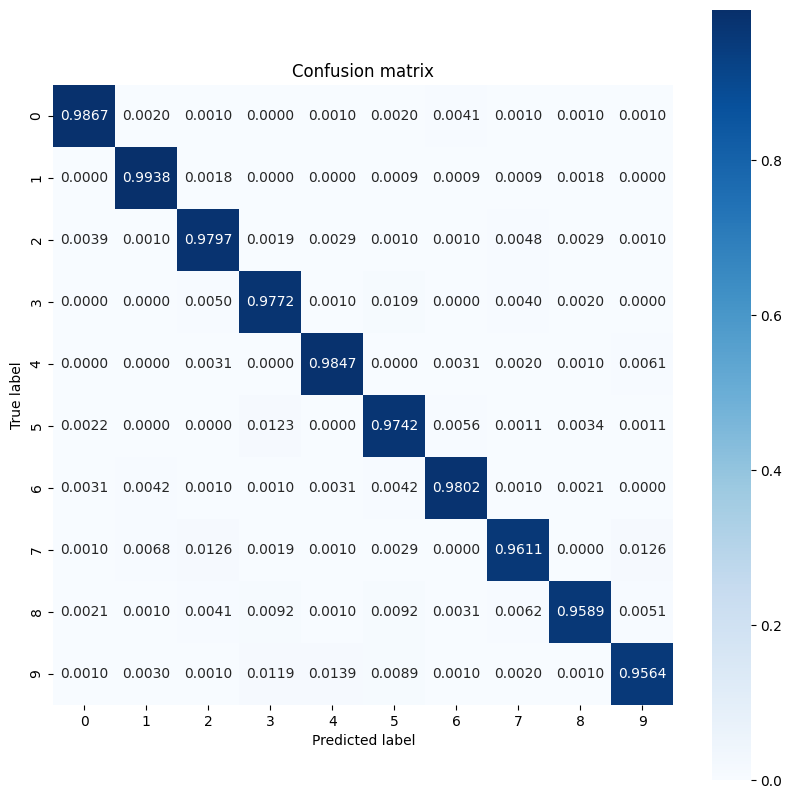

In [346]:
show_confusion_matrix(y_test, test_classes)

In [347]:
precision = precision_score(y_test, test_classes, average='macro')  
recall = recall_score(y_test, test_classes, average='macro')  

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.9753271885414303
Recall: 0.9752967690872849
